In [8]:
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Ignoring future warnings in Python
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [6]:
# Paths
model_path = '../models/xgb.pkl'
data_path = '../data/preprocessed.csv'

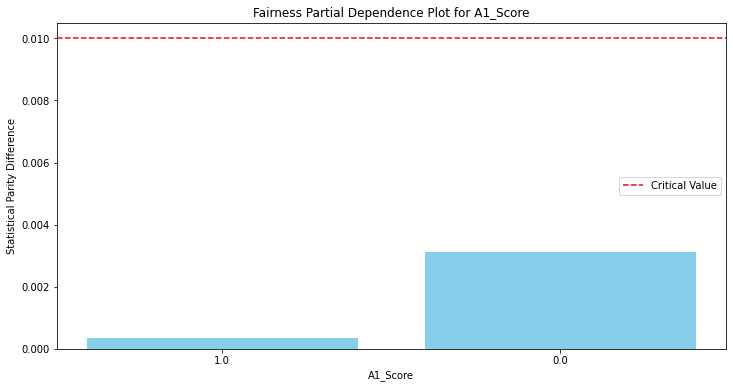

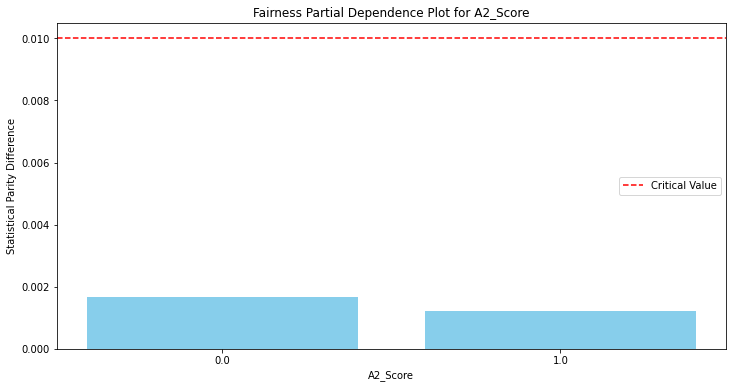

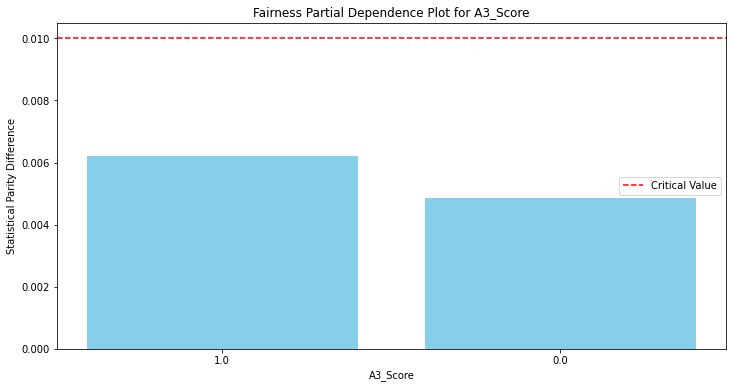

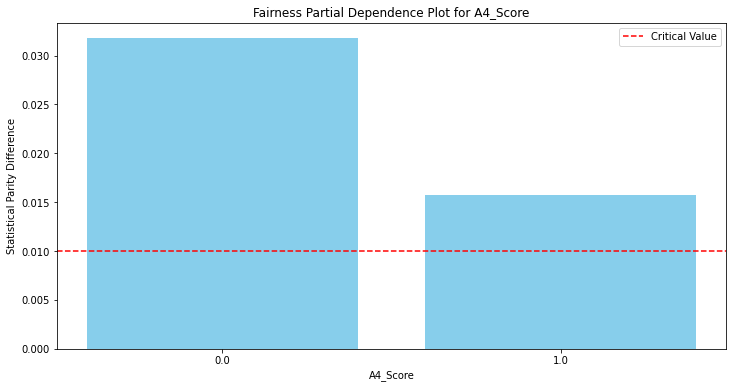

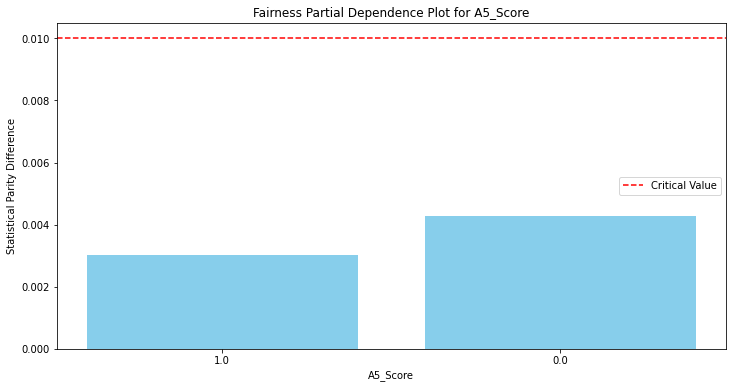

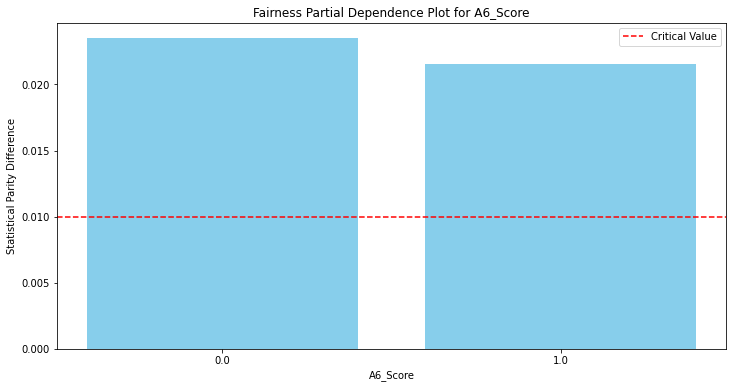

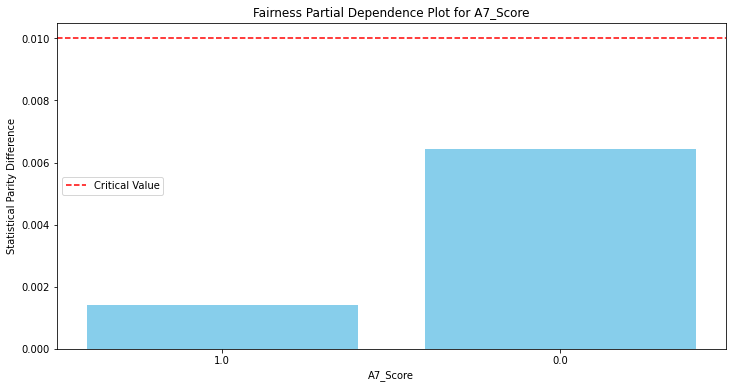

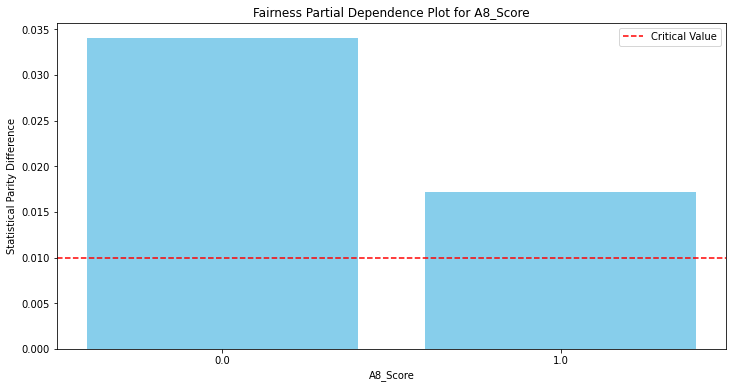

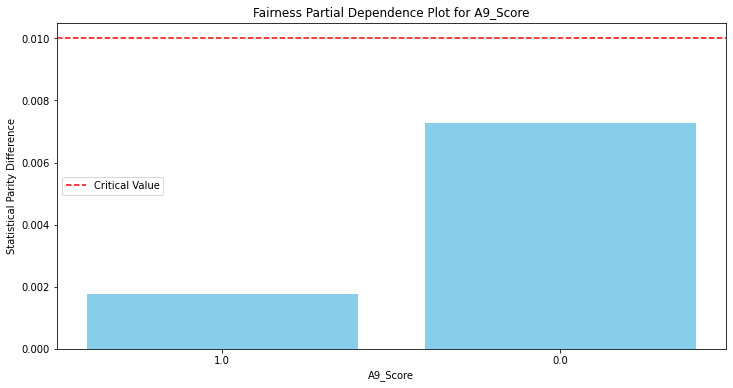

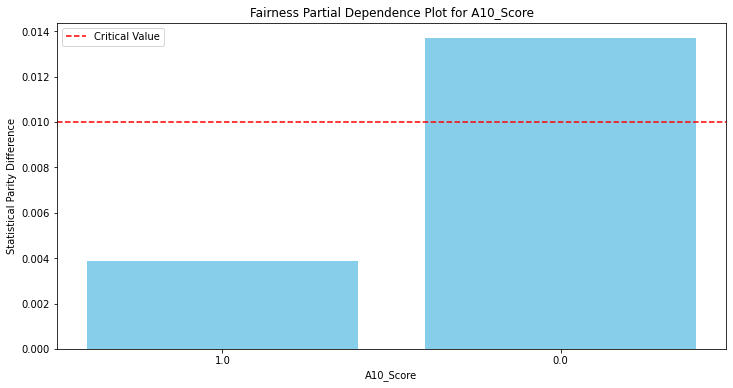

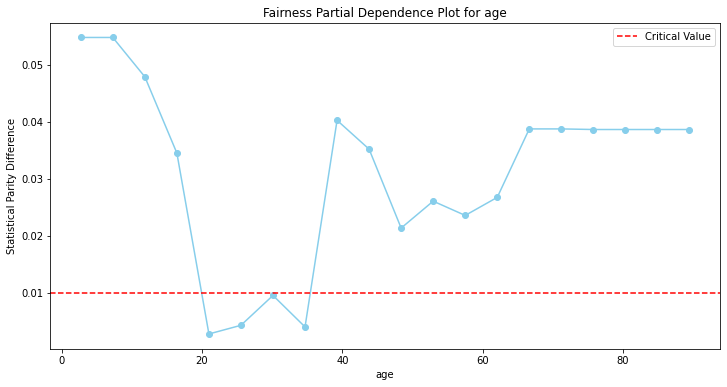

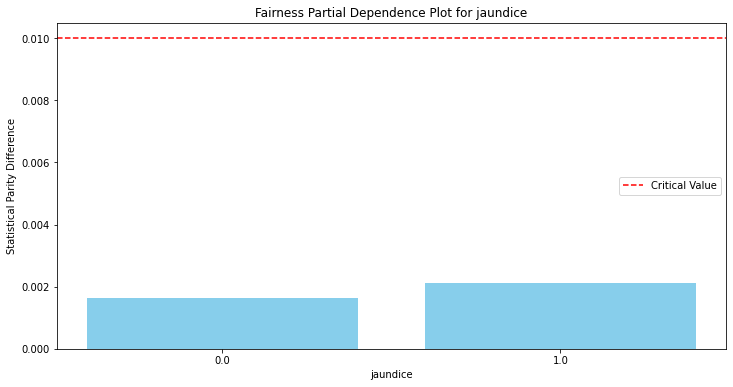

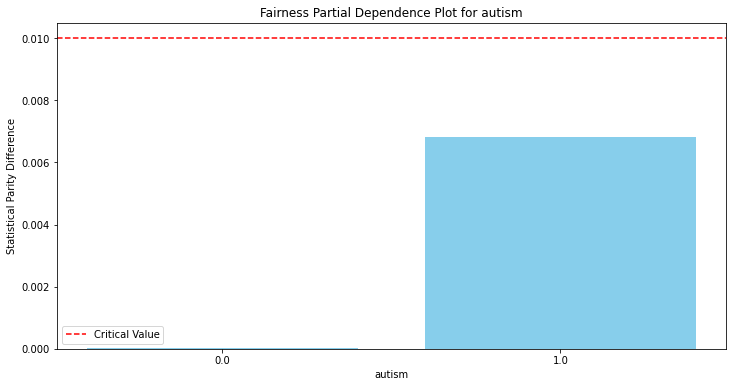

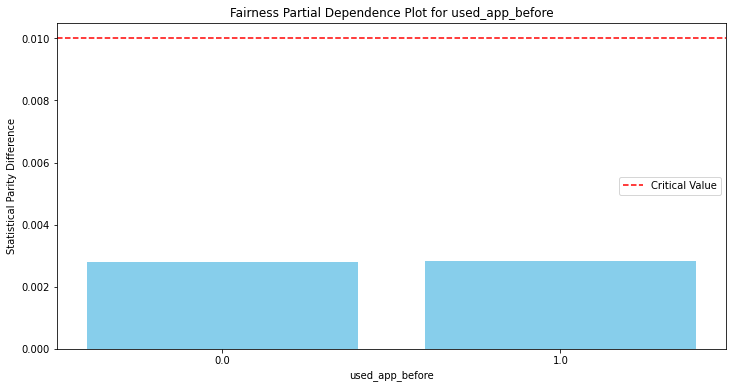

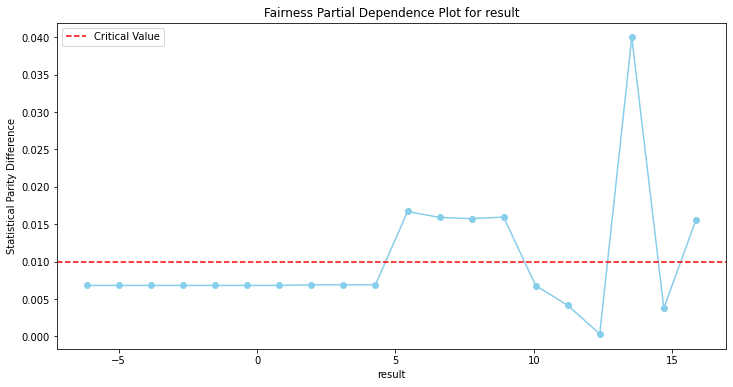

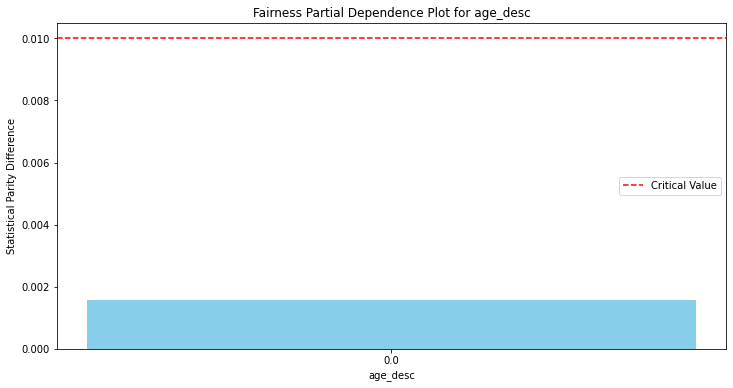

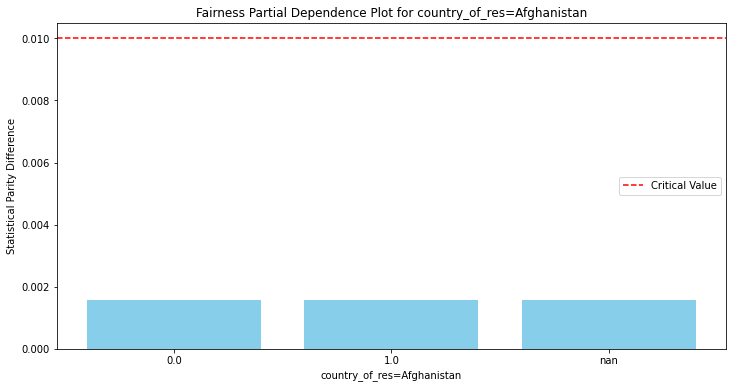

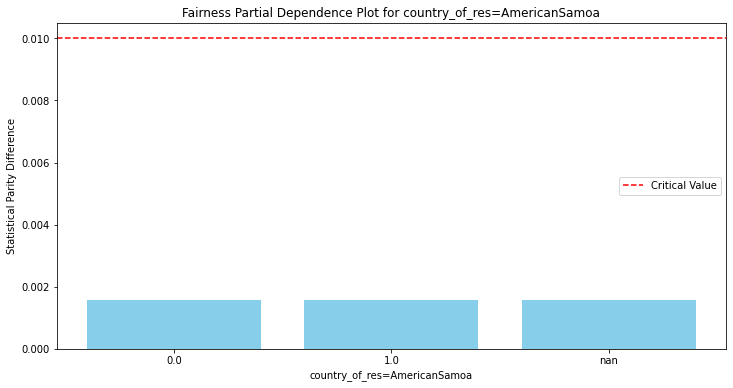

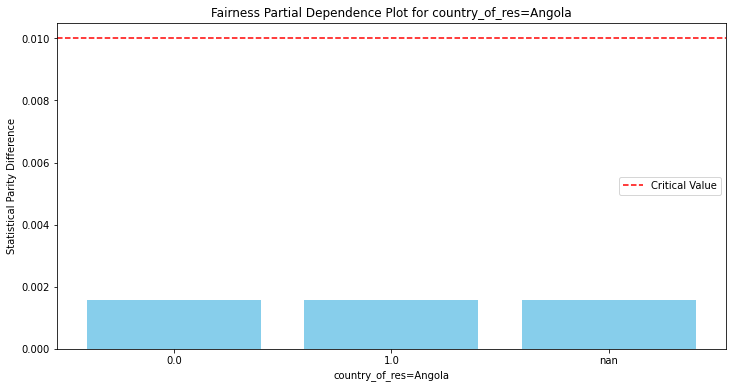

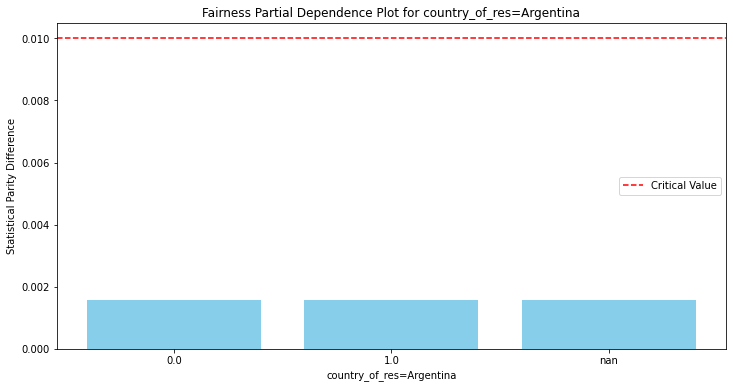

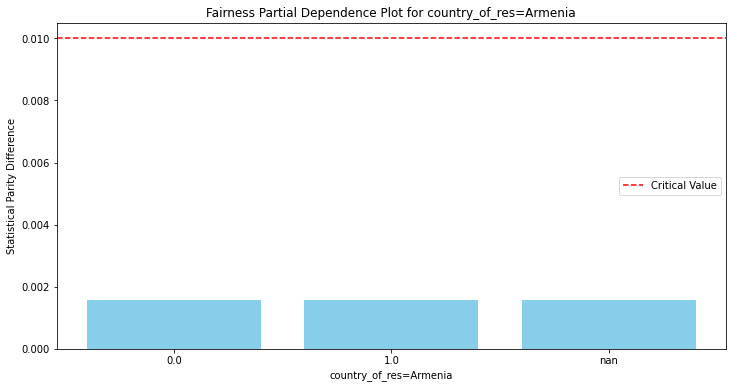

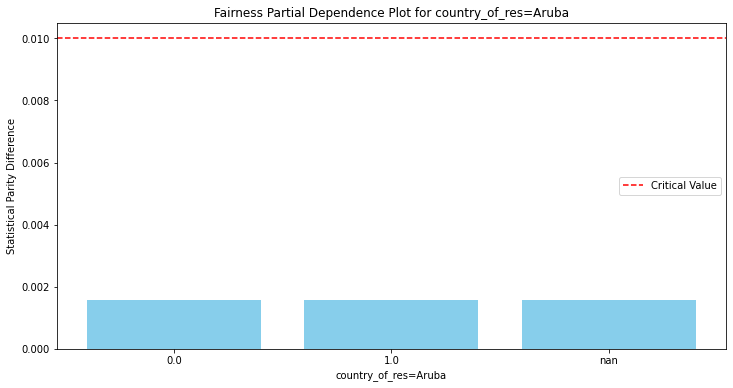

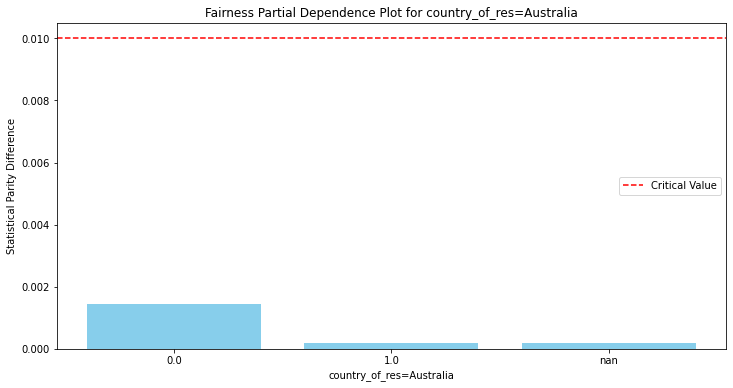

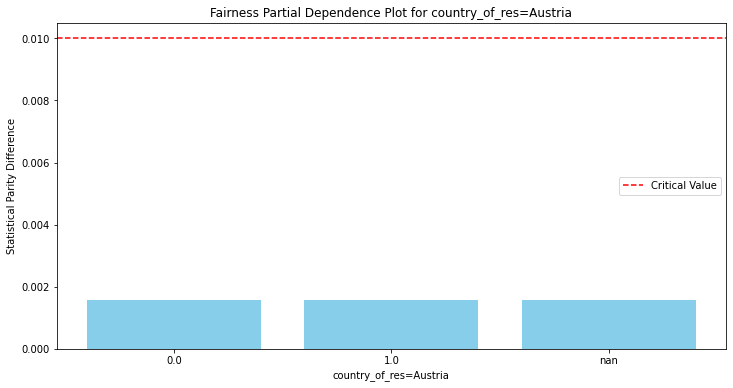

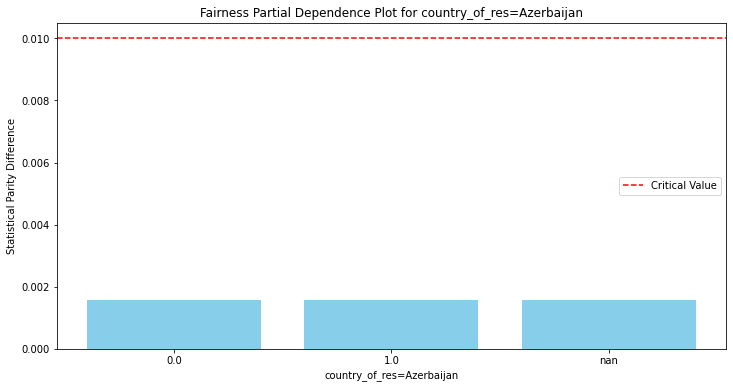

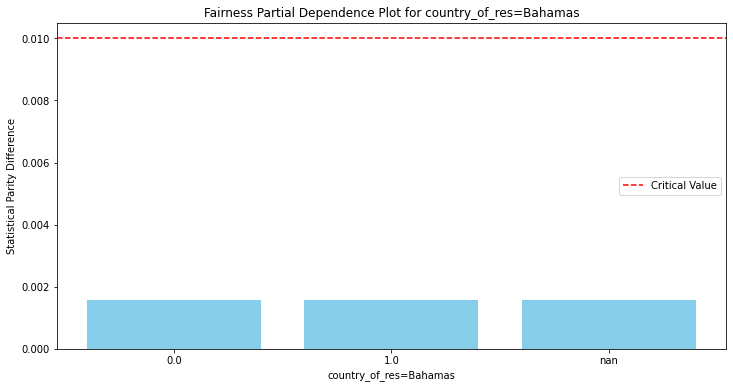

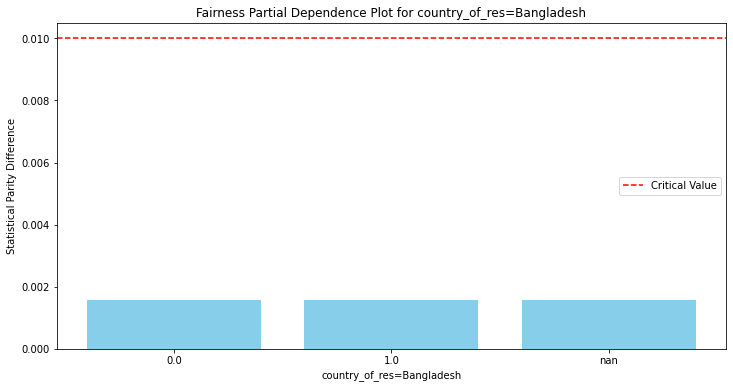

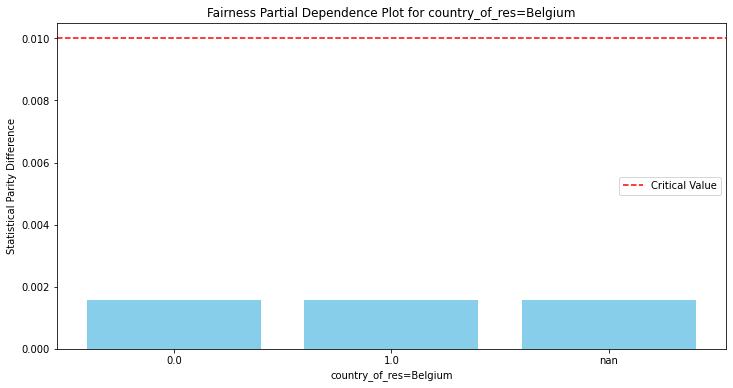

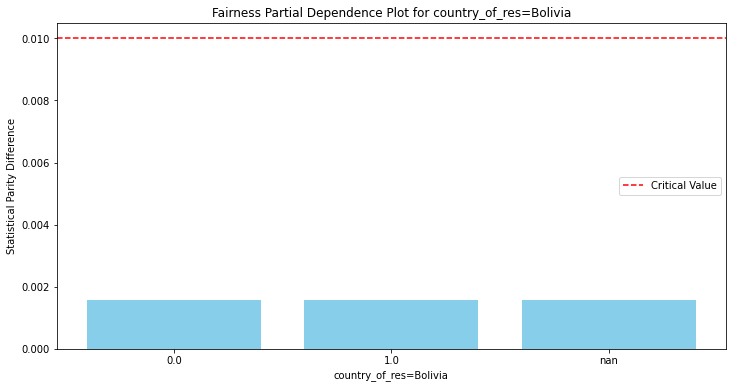

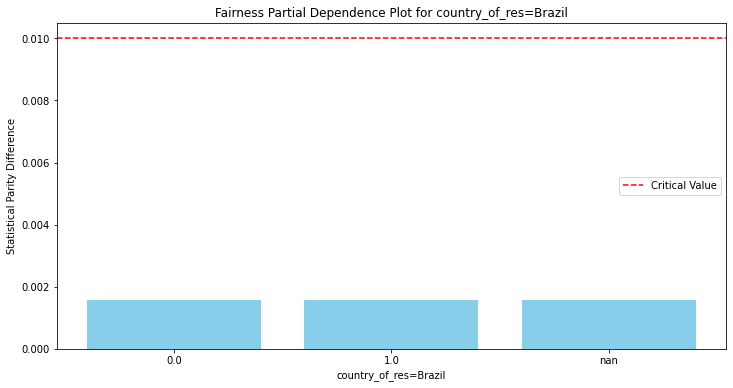

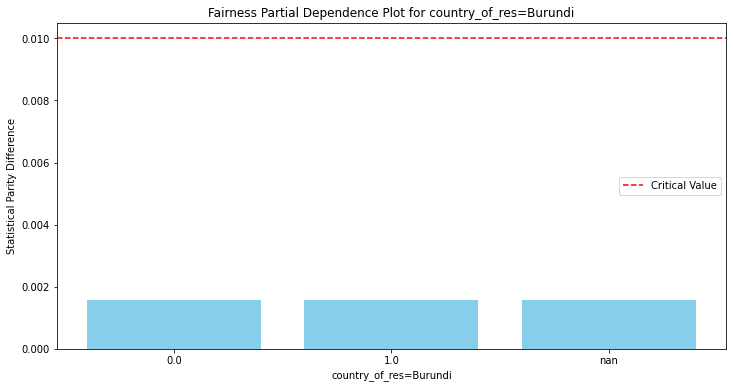

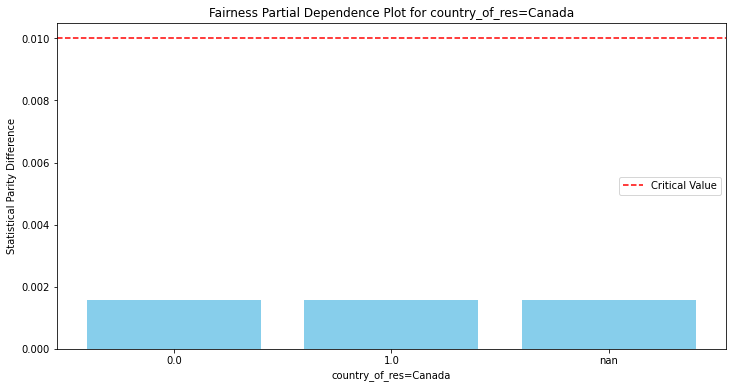

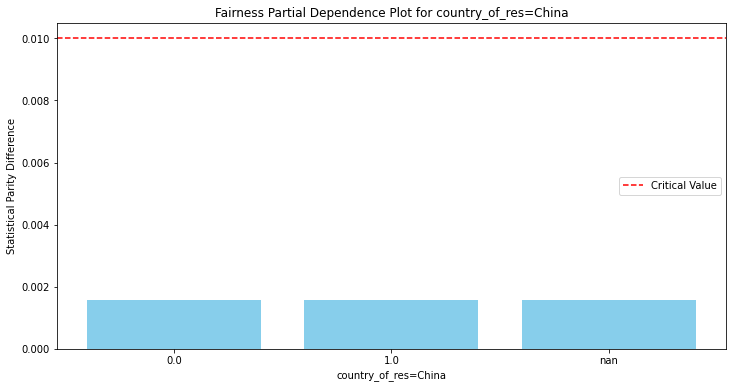

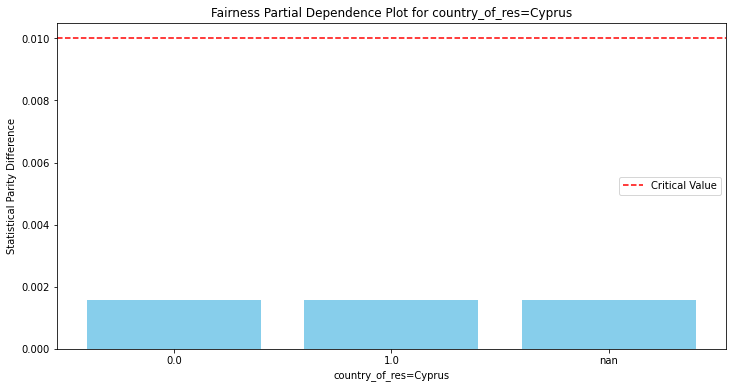

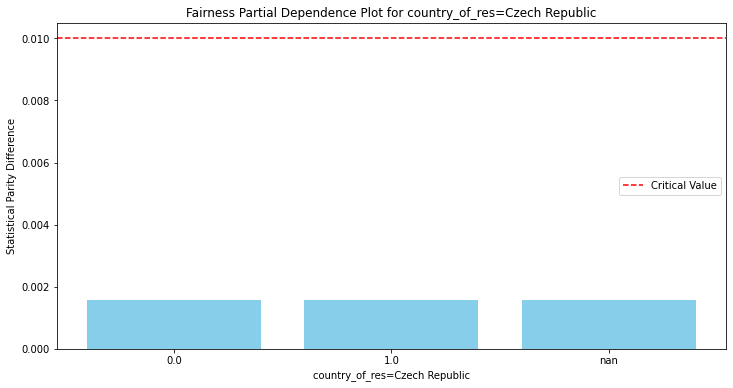

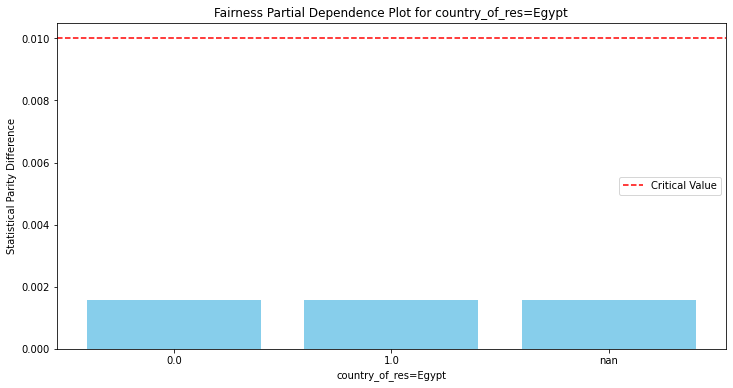

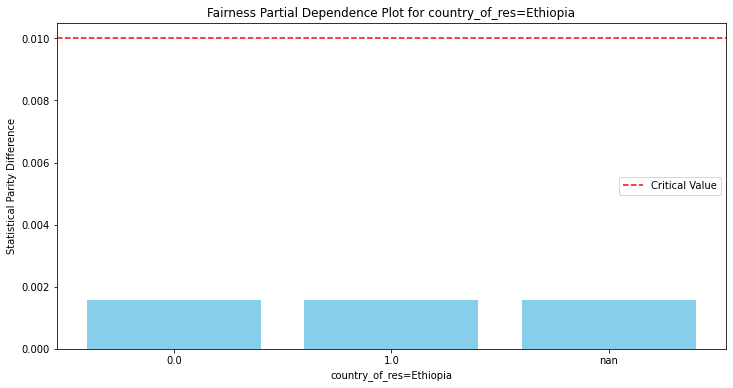

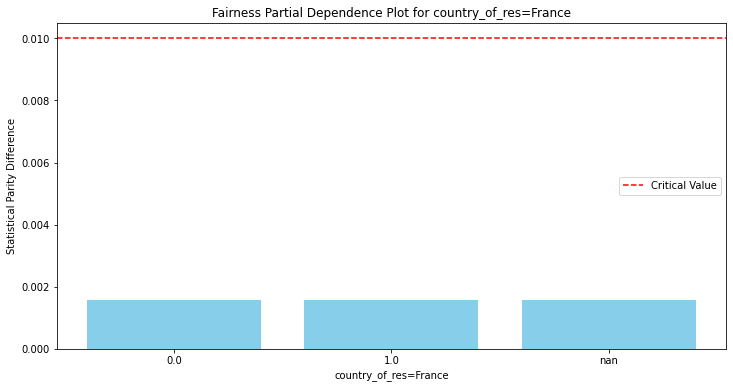

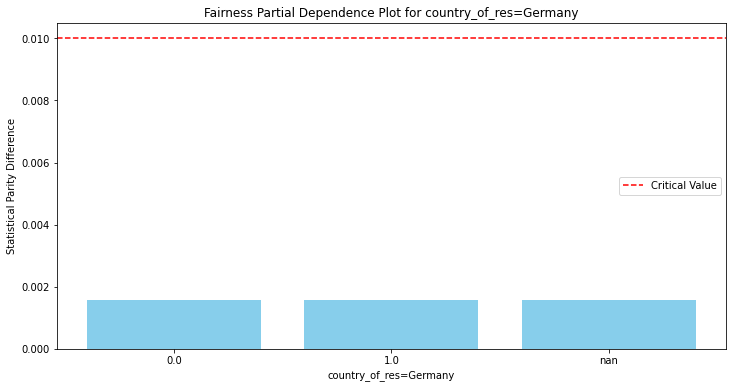

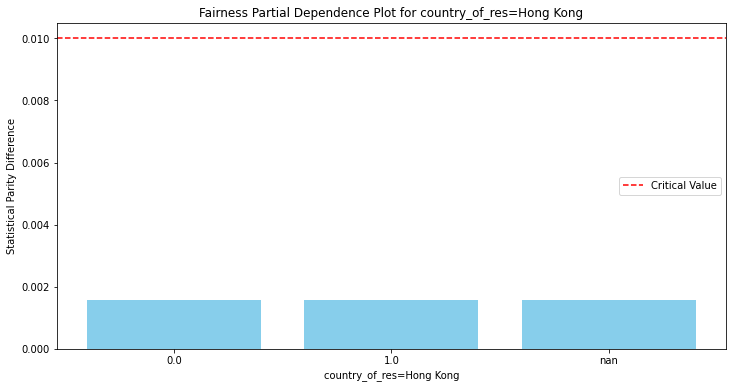

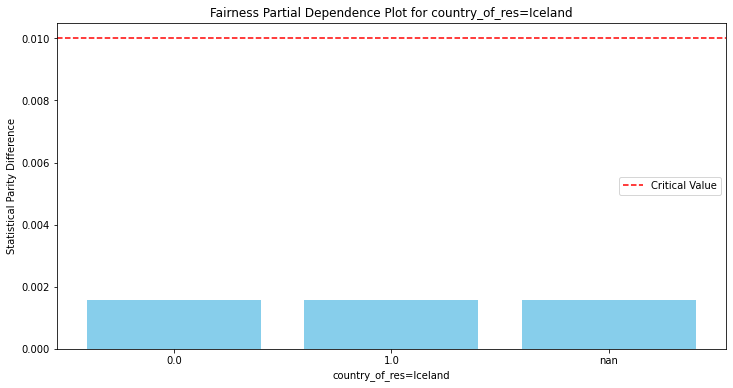

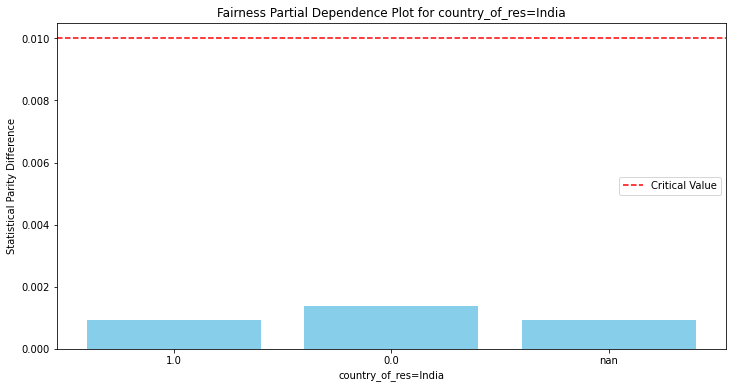

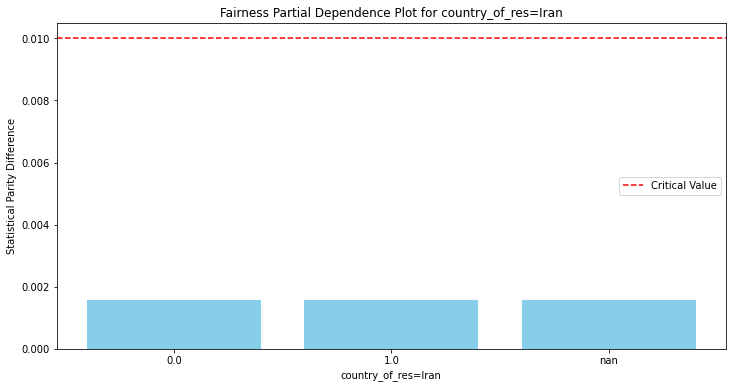

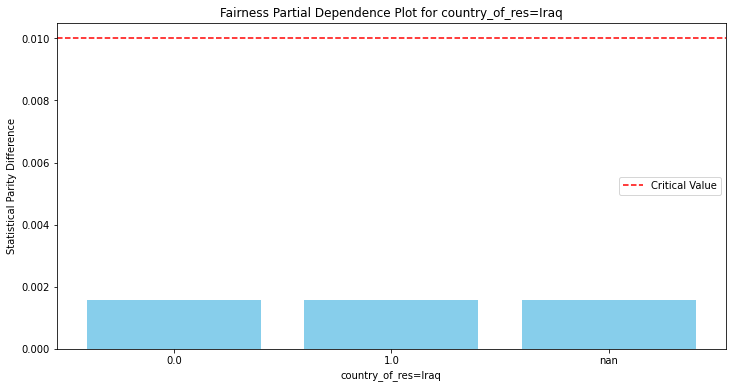

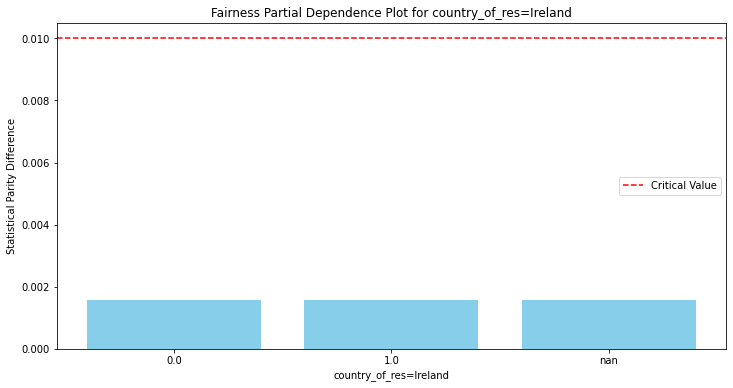

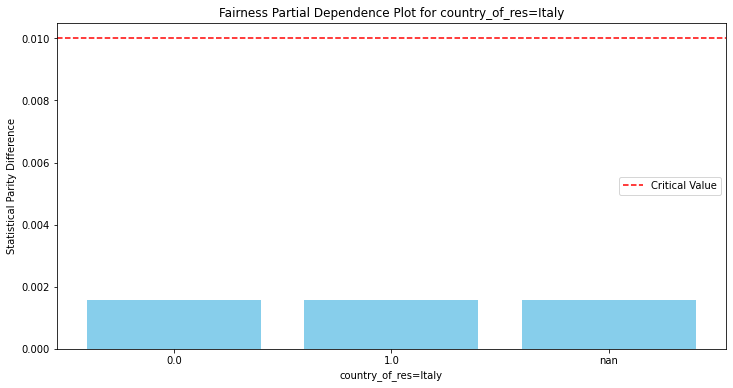

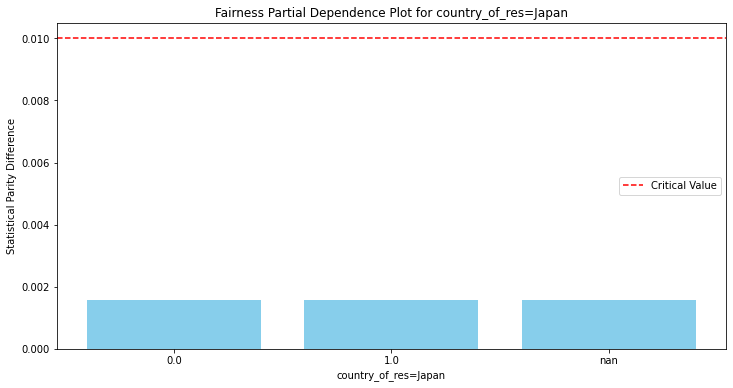

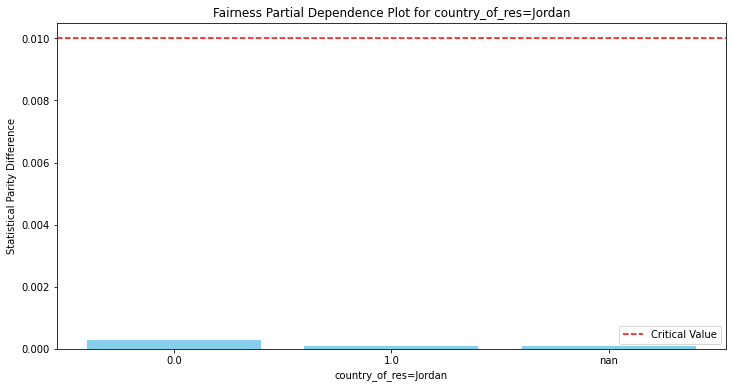

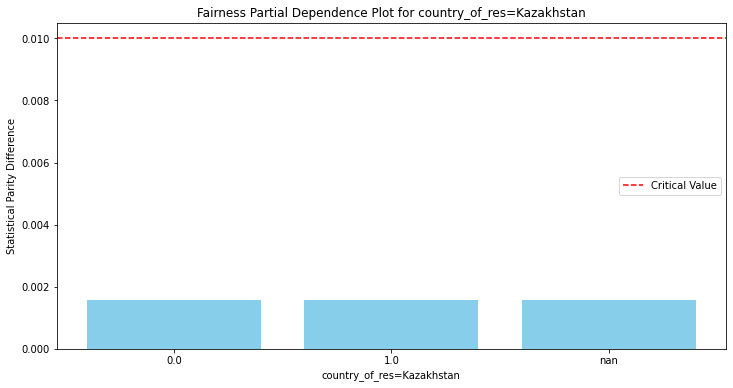

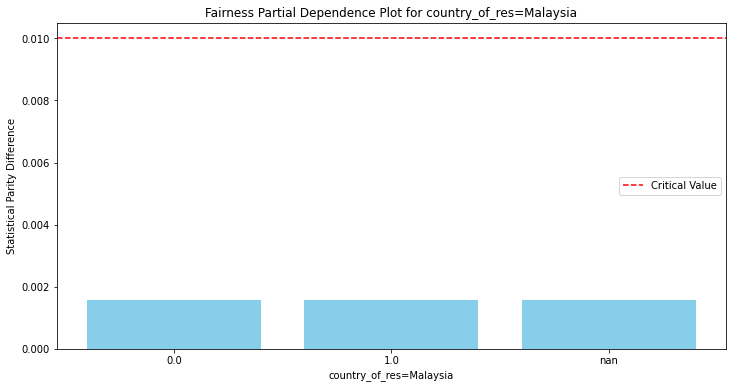

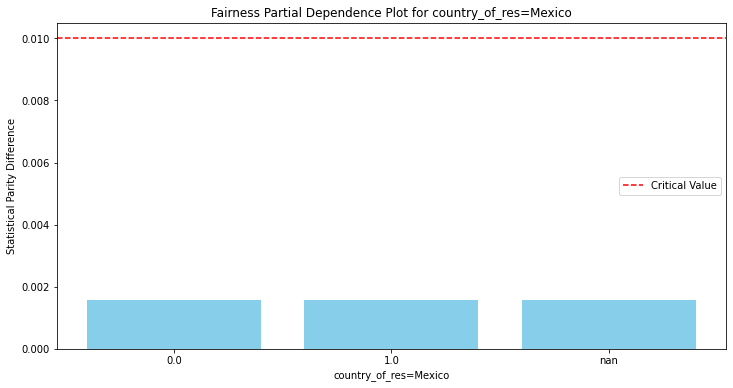

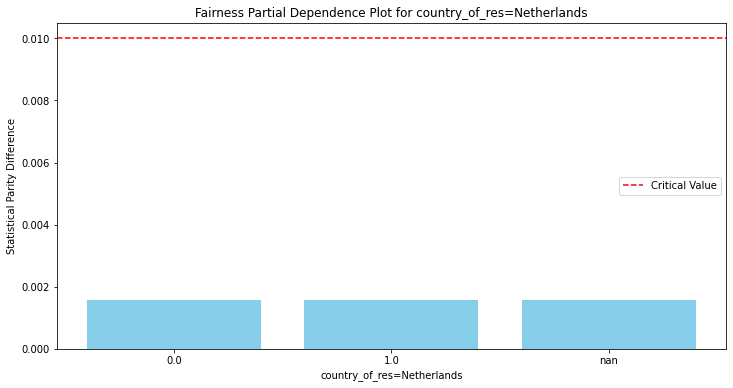

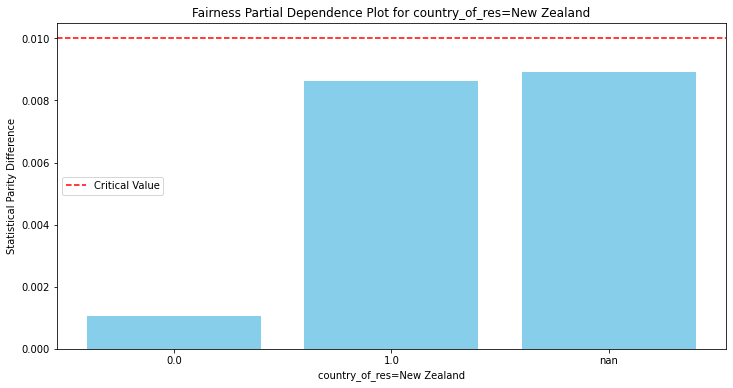

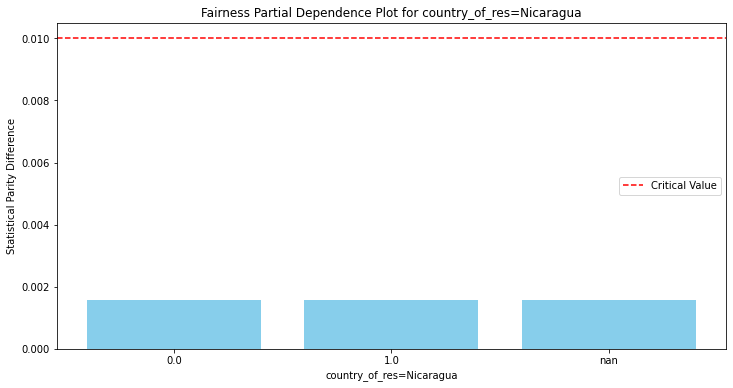

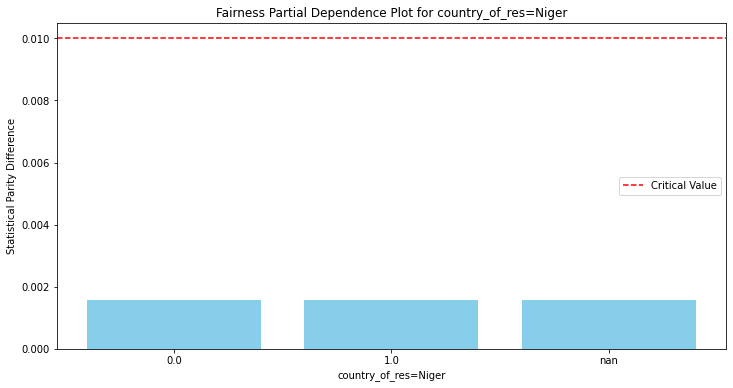

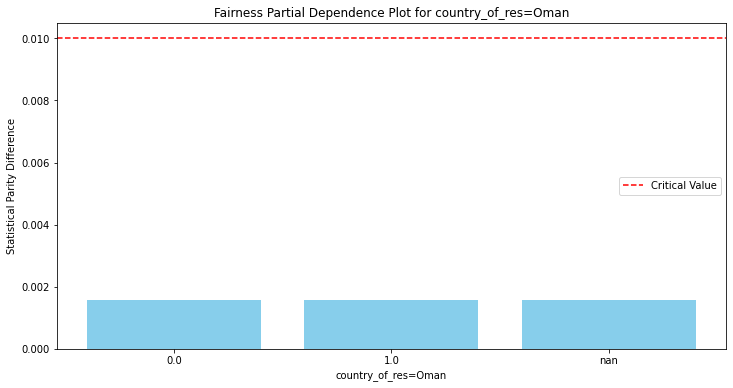

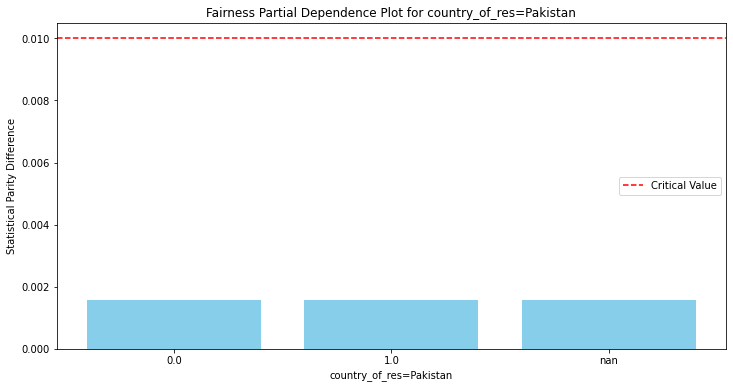

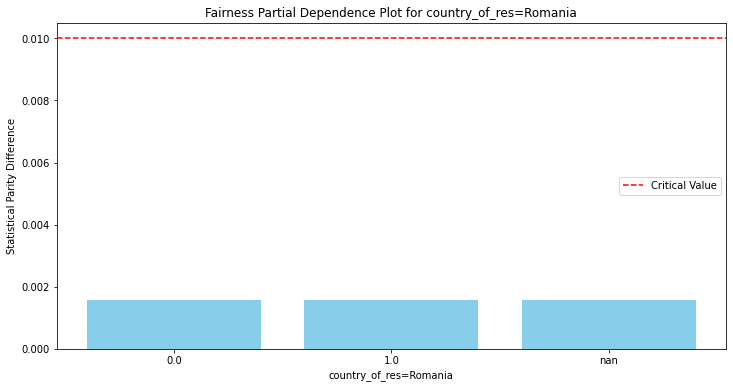

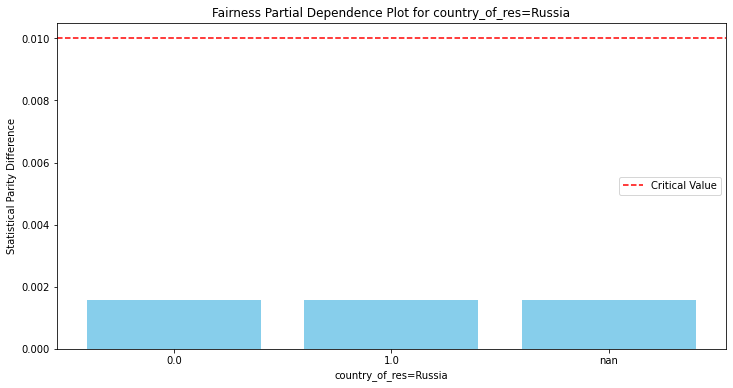

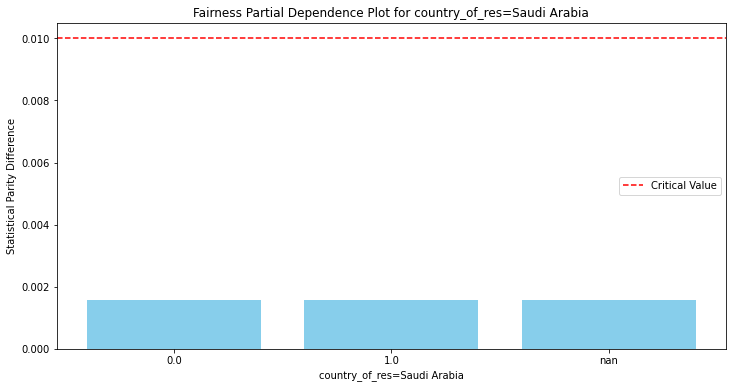

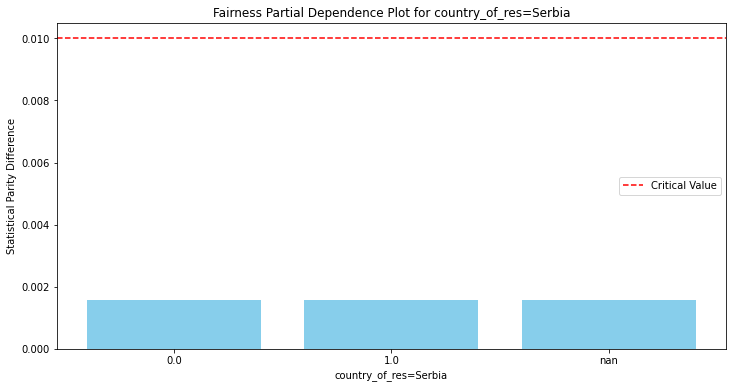

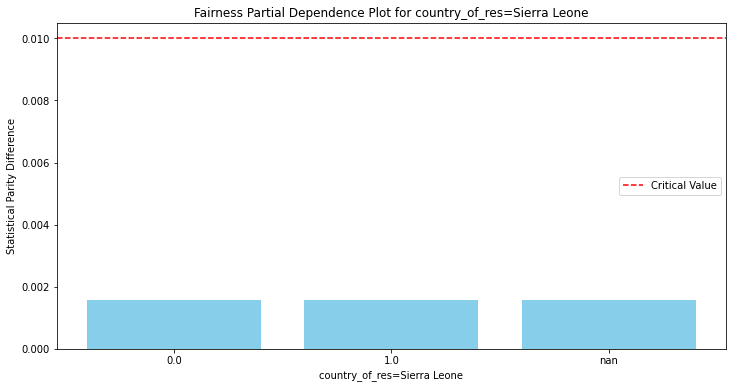

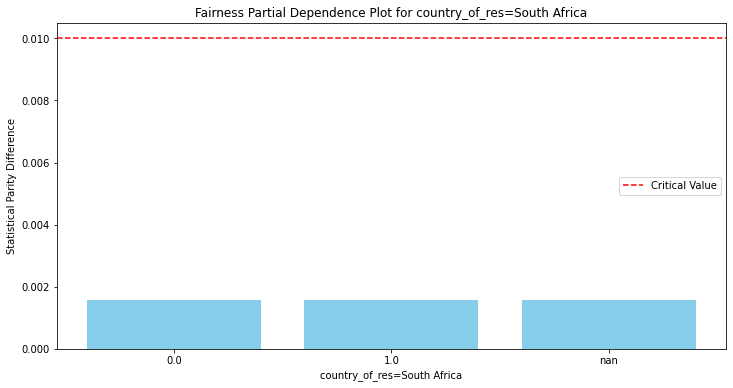

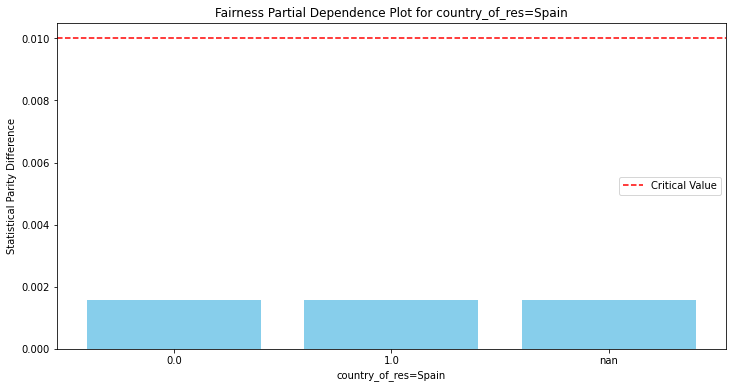

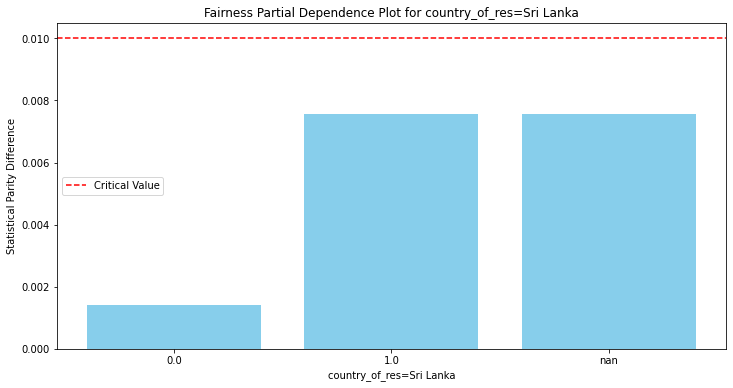

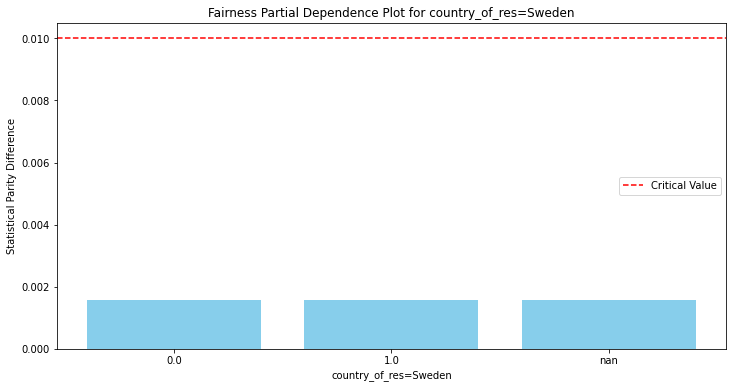

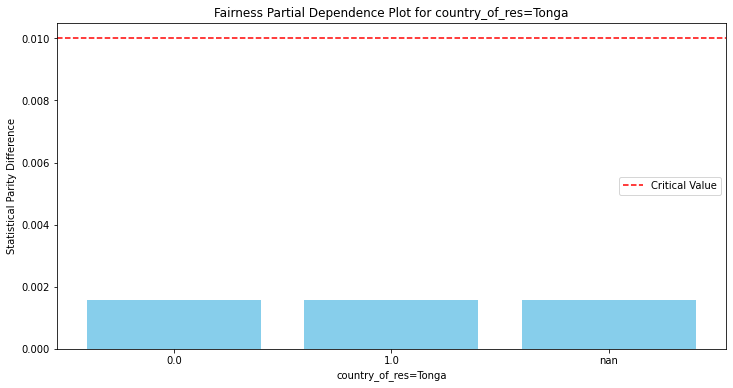

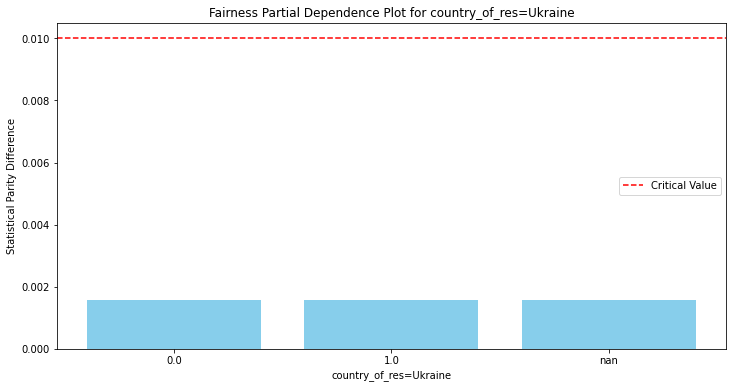

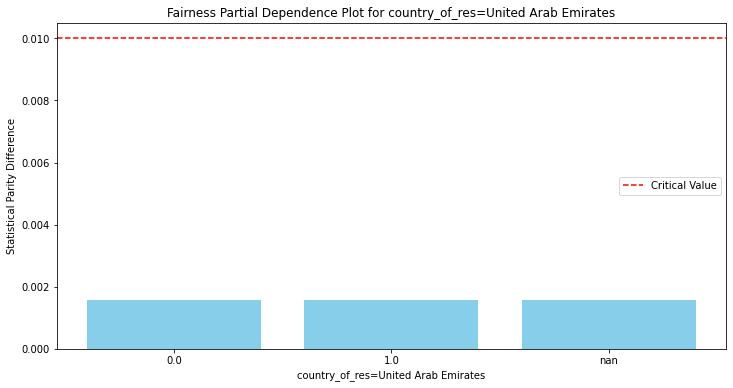

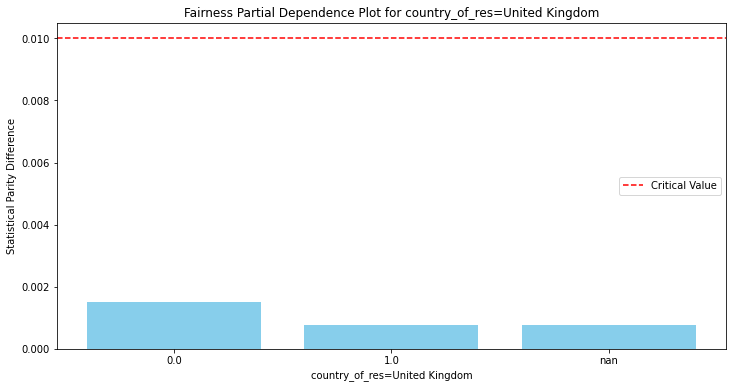

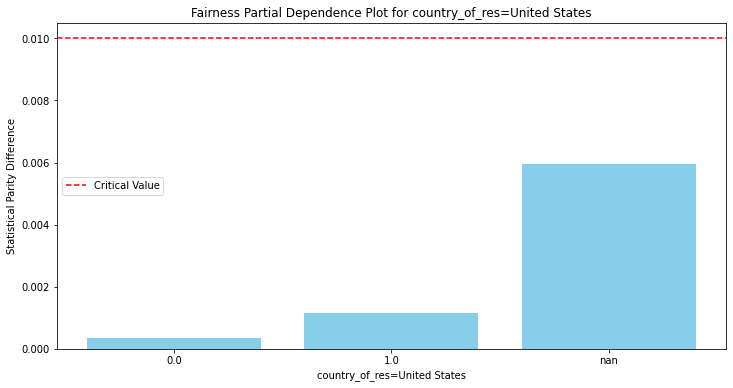

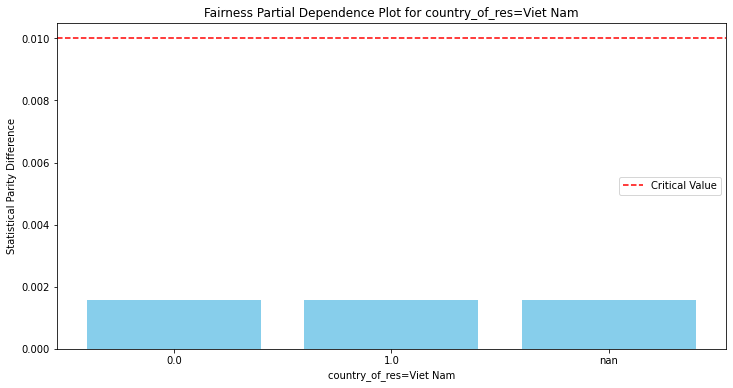

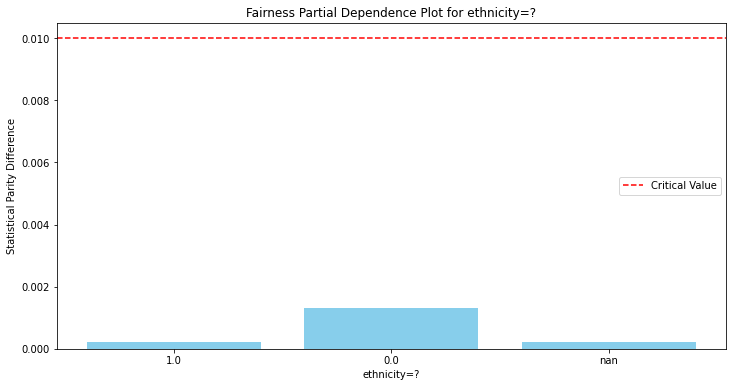

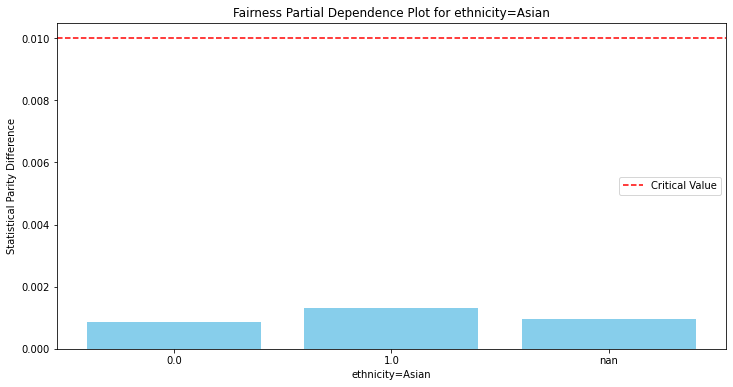

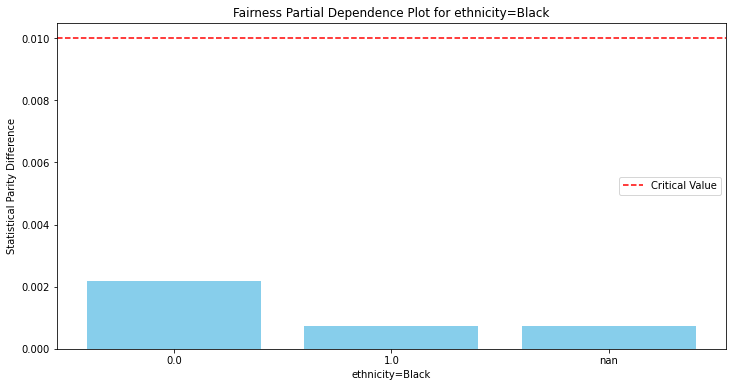

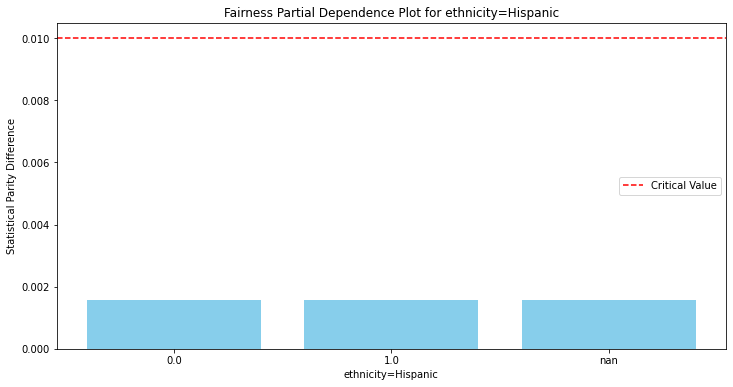

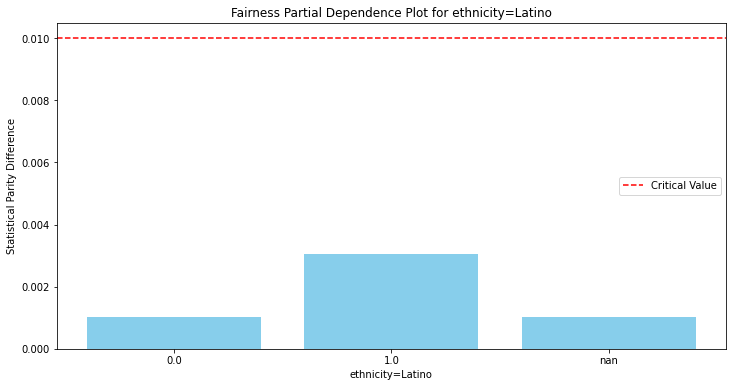

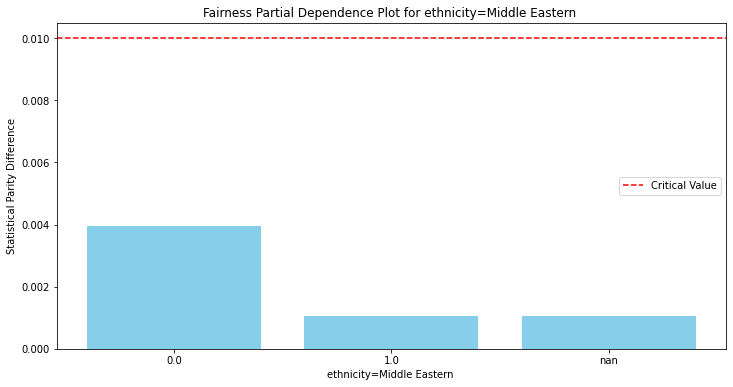

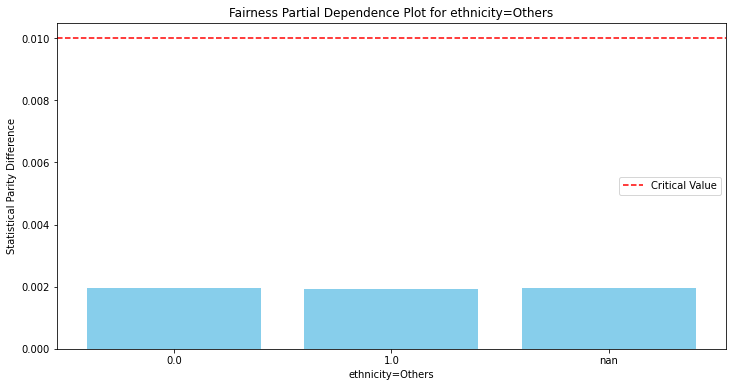

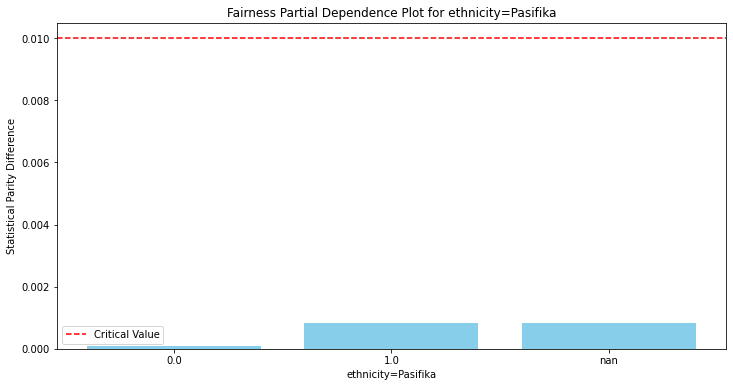

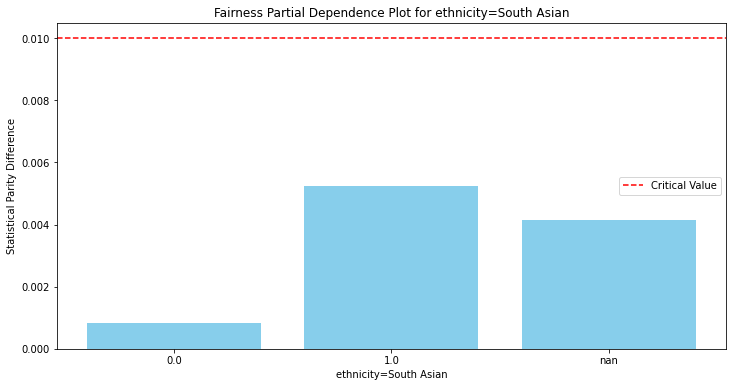

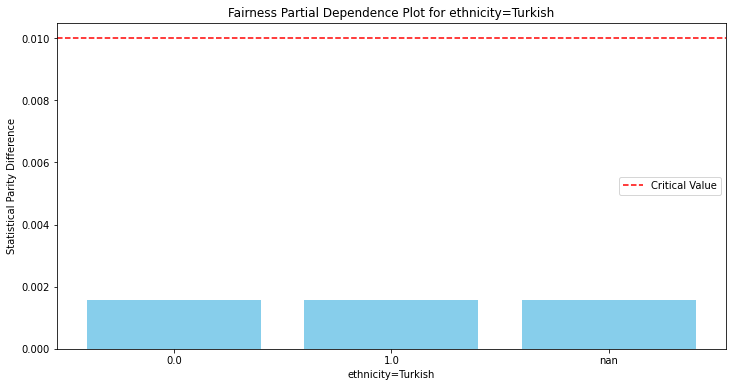

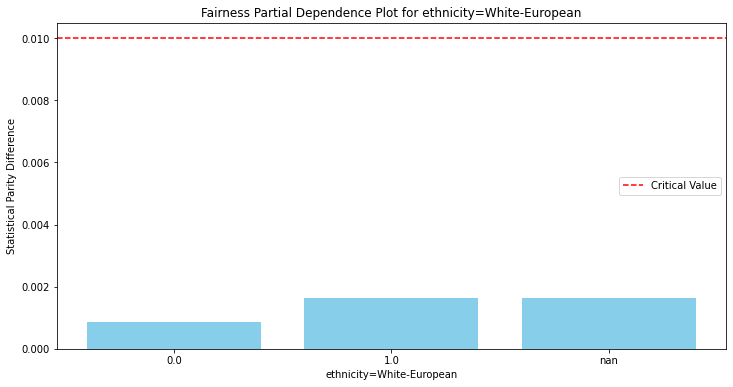

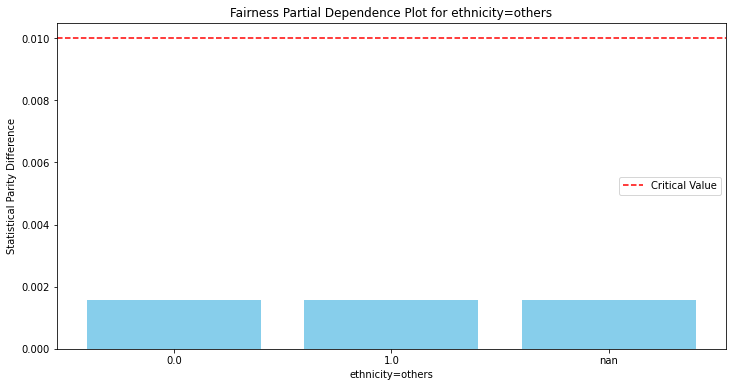

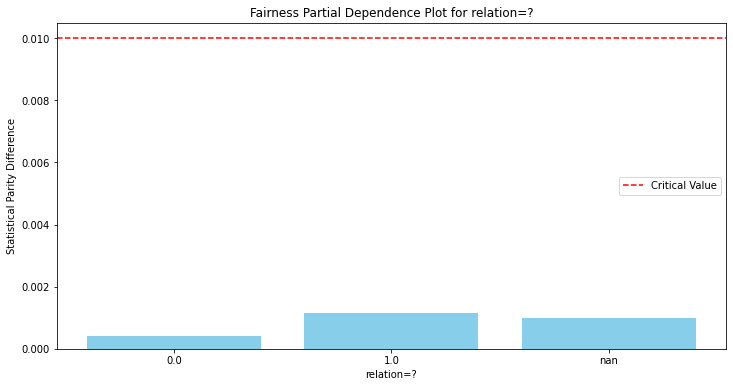

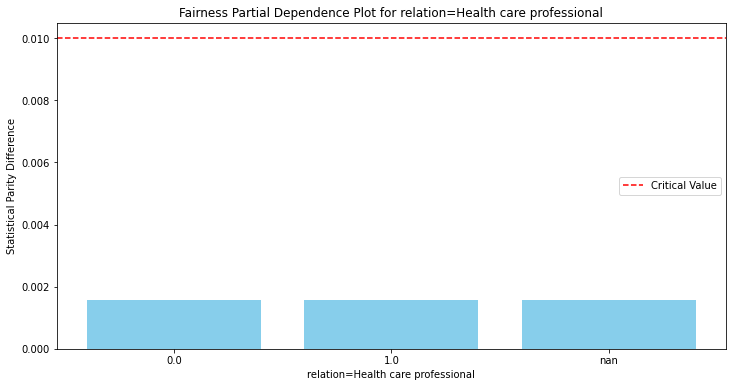

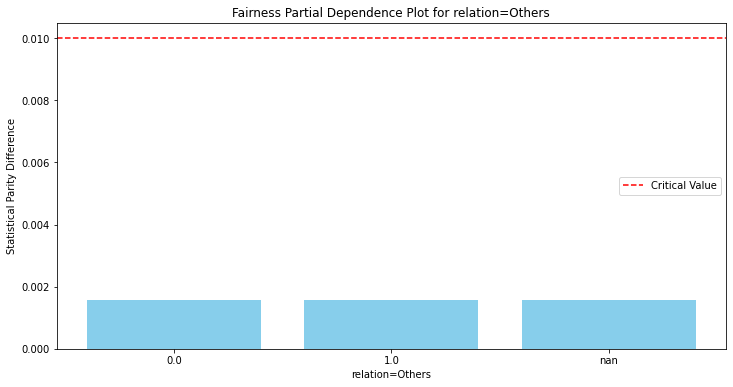

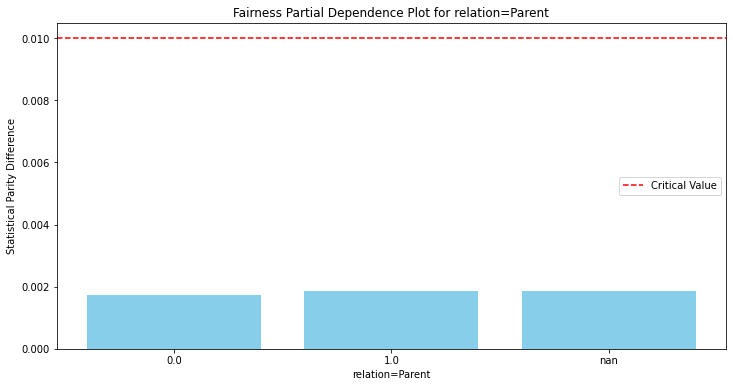

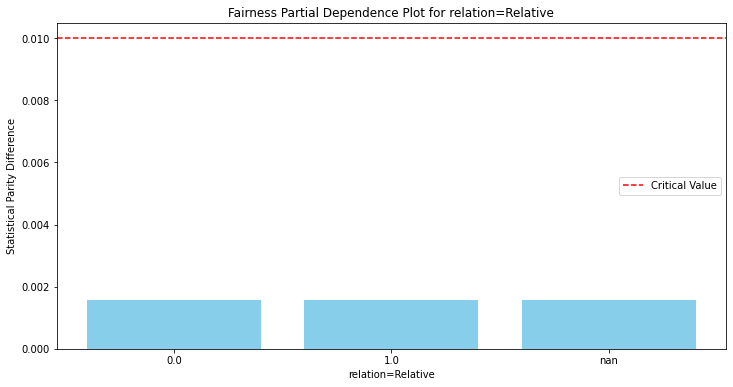

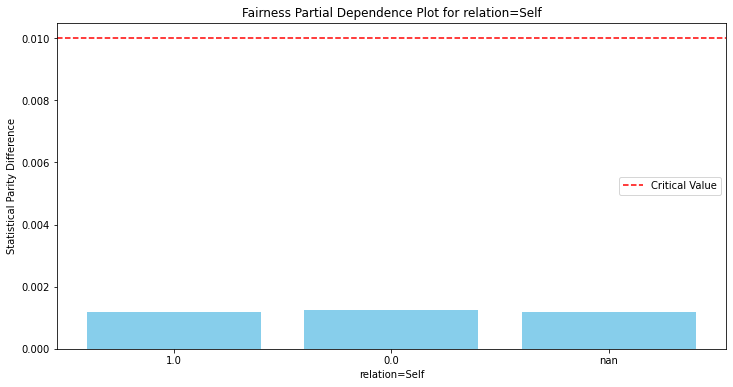

Overall accuracy of the model: 0.96625


In [9]:
# Load the XGBoost model
with open(model_path, 'rb') as file:
    xgb_model = pickle.load(file)

# Load the dataset
data = pd.read_csv(data_path)
X = data.drop(columns=['Class/ASD']) 
y = data['Class/ASD']

# Statistical Parity Function
def statistical_parity(model, X, sensitive_feature, sensitive_feature_value, feature_to_test, feature_value):
    X_temp = X.copy()
    X_temp[feature_to_test] = feature_value
    predictions = model.predict_proba(X_temp)[:, 1]  
    
    # Calculate probabilities for the protected group
    protected_group_prob = predictions[X_temp[sensitive_feature] == sensitive_feature_value].mean()
    # Calculate probabilities for the unprotected group
    unprotected_group_prob = predictions[X_temp[sensitive_feature] != sensitive_feature_value].mean()

    # Statistical parity is the absolute difference in probabilities
    return abs(protected_group_prob - unprotected_group_prob)

# Plot FPDP for each feature
def plot_fpdp_for_all_features(model, X, sensitive_feature, protected_value, critical_value):
    for feature in X.columns:
        if feature == sensitive_feature or feature.endswith(sensitive_feature):  # Skip the protected feature itself
            continue

        is_categorical = True if 'Score' in feature or X[feature].nunique() < 10 else False  # Detect if the feature is categorical

        values = []
        parity_differences = []

        if is_categorical:
            categories = X[feature].unique()
            for category in categories:
                parity_diff = statistical_parity(model, X, sensitive_feature, protected_value, feature, category)
                values.append(category)
                parity_differences.append(parity_diff)
            
            plt.figure(figsize=(12, 6))
            plt.bar([str(v) for v in values], parity_differences, color='skyblue')
        
        else:
            # Continuous feature, vary over a range
            min_value, max_value = X[feature].min(), X[feature].max()
            values = np.linspace(min_value, max_value, num=20)
            for value in values:
                parity_diff = statistical_parity(model, X, sensitive_feature, protected_value, feature, value)
                parity_differences.append(parity_diff)
            
            plt.figure(figsize=(12, 6))
            plt.plot(values, parity_differences, marker='o', linestyle='-', color='skyblue')

        plt.axhline(y=critical_value, color='red', linestyle='--', label='Critical Value')
        plt.xlabel(feature)
        plt.ylabel('Statistical Parity Difference')
        plt.title(f'Fairness Partial Dependence Plot for {feature}')
        plt.legend()
        plt.show()

plot_fpdp_for_all_features(xgb_model, X, 'gender', protected_value=0, critical_value=0.01)

# Calculate and print overall accuracy of the model
predictions = xgb_model.predict(X)
accuracy = accuracy_score(y, predictions)
print(f'Overall accuracy of the model: {accuracy}')
